In [1]:
#Import Mods
import pandas as pd
import numpy as np

import glob

import matplotlib.pyplot as plt

from datetime import datetime
from datetime import timedelta

import metpy.calc as mpcalc
from metpy.units import units

from PIL import Image, ImageDraw

In [2]:
#Selected files to create the mask. Second image creates a better mask.

#file = pd.read_csv("/lcrc/project/waggle/public_html/private/training_data/waggle_area510/mobotix/"
#                  "thermal/1618762640_000001_right_336x252_14bit.thermal.celsius.csv")


file = pd.read_csv("/lcrc/project/waggle/public_html/private/training_data/waggle_area510/mobotix/"
                "thermal/1618776148_000001_right_336x252_14bit.thermal.celsius.csv")

In [12]:
#Create image list by unpacking data from CSV and placing in correct spot.
image_array = []

for i in range(file.size):
    if i >= 6:
        data = file.values[i][0]
        data = data.split(';')
        array = np.array(data)
        array = array.astype(np.float)
        image_array.append(array)
        

In [5]:
#Create mask list with threshold value.
mask_col = []

for j in image_array:
    mask_row = []
    for k in range(len(j)):
        
        if k > 160 and k < 210:
            
            if j[k] > 19.75:
                mask_row.append(1)
            else:
                mask_row.append(0)
                
        else:
            mask_row.append(0)

    mask_col.append(mask_row)
            

In [6]:
#create mask array and a find x-y values of for desired area
mask_array = np.array(mask_col)
x, y = np.nonzero(mask_array)

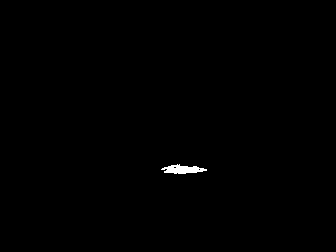

In [13]:
#Create image with with mask array
#This shape is a rectangle given the top left corner and botttom right corner
#shape = [(160, 150), (210, 190)]

#Tranform list into array and convert all true values from 1 to 255 as well as use an unsigned 8-bit integer dtype.
array = np.array(mask_col).astype('uint8')*255

#create image
im = Image.fromarray(array)

#img1 = ImageDraw.Draw(im)
#img1.rectangle(shape, fill = 12 , outline ="red")
#im.save('Mulch_Mask.png')
im

In [8]:
#Grab files from directory and sort them into correct order
files = []
for filename in glob.glob("/lcrc/project/waggle/public_html/private/training_data/waggle_area510/mobotix/thermal/"
                          "*.thermal.celsius.csv"):
    files.append(filename)
files.sort()

In [9]:
#Run through all images and save off average temperature for each
temp_avg = []
temp_med = []
image_count = []
image_time = []


for path in files:
    file = pd.read_csv(path)
    image_time.append(datetime.fromtimestamp(int(path[86:96])) + timedelta(hours = 5))
    image_array = []
    mask_image = []
    
    
    for i in range(file.size):
        if i >= 6:
            data = file.values[i][0]
            data = data.split(';')
            array = np.array(data)
            array = array.astype(np.float)
            image_array.append(array)
            
    image_array = np.array(image_array)
    
    temp_avg.append(np.mean(image_array[x, y]))
    temp_med.append(np.median(image_array[x, y]))

In [10]:
#Convert units from Celsius to Fahrenheit
temp_avgc = temp_avg * units.celsius
temp_medc = temp_med * units.celsius

temp_avgf = temp_avgc.to(units.fahrenheit)
temp_medf = temp_medc.to(units.fahrenheit)

Text(0.5, 1.0, 'Thermal Camera Average Comparison with KLOT ASOS')

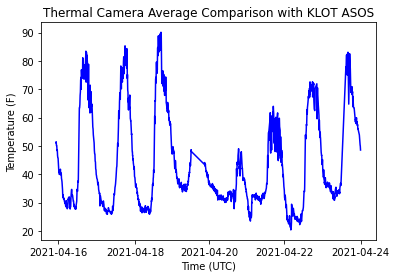

In [11]:
#Create plot
plt.plot(image_time, temp_avgf, color = 'blue')

plt.xlabel('Time (UTC)')
#image_time = np.array(image_time)
plt.xticks((image_time[11], image_time[344], image_time[796], image_time[1212], image_time[1523]))
plt.ylabel('Temperature (F)')

plt.title('Mulch Area Average Thermal Measurement ')
